In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import os

Read input data

In [2]:
shops = pd.read_csv("data/shops.csv")
item_categories = pd.read_csv("data/item_categories.csv")
sales_train = pd.read_csv("data/sales_train.csv")
items = pd.read_csv("data/items.csv")

test = pd.read_csv("data/test.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")

Stack the train and test data together

In [16]:
test['date_block_num'] = 34
train_test = sales_train.append(test.drop(columns=['ID']))
train_test.tail(2)

C:\Users\ChenP\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


,date,date_block_num,item_cnt_day,item_id,item_price,shop_id
214198,NaN,34,NaN,19648,NaN,45
214199,NaN,34,NaN,969,NaN,45


## Feature Engineering

Aggregate sales to monthly level and clip the value, according to the competition rule

In [4]:
# Aggregate the sales by month

train = sales_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})
train.columns = ['item_cnt_sum']
train.reset_index(inplace=True)
train['item_cnt_sum'] = np.clip(train['item_cnt_sum'], 0, 20)

Let's look at the statistics for the target variable to make sure

In [5]:
train['item_cnt_sum'].describe()

count    1.609124e+06
mean     2.022806e+00
std      2.577964e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.000000e+01
Name: item_cnt_sum, dtype: float64

Notice that we do not have all the (date_block_num, shop_id, item_id) pairs, if the sales = 0. Therefore, we need to fill in the missing pairs.

In [6]:
from itertools import product

months = train['date_block_num'].unique()

cartesian = []
for month in months:
    shops_in_month = train.loc[train['date_block_num']==month, 'shop_id'].unique()
    items_in_month = train.loc[train['date_block_num']==month, 'item_id'].unique()
    cartesian.append(np.array(list(product(*[shops_in_month, items_in_month, [month]])), dtype='int32'))
    
cartesian_df = pd.DataFrame(np.vstack(cartesian), columns = ['shop_id', 'item_id', 'date_block_num'], dtype=np.int32)
print(cartesian_df.shape)

(10913850, 3)


The generated cartesian_df dataframe will contain all the unique (shop_id, item_id, date_block_num) pairs

Append the test set into the cartesian_df

In [7]:
test['date_block_num'] = 34
cartesian_df = cartesian_df.append(test.drop(columns=['ID']))

We merge it back to the train dataframe and fill NaN with zeros to include zeros in the sales record

In [8]:
new_train = cartesian_df.merge(train, on=['date_block_num','shop_id','item_id'], how='left').fillna(0)
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_sum
0,0,32,0,6.0
1,0,33,0,3.0
2,0,35,0,1.0
3,0,43,0,1.0
4,0,51,0,2.0


In [10]:
new_train = new_train.merge(items, on='item_id', how='left')
new_train = new_train.merge(shops, on='shop_id', how='left')
new_train = new_train.merge(item_categories, on='item_category_id', how='left')
new_train['city'] = new_train['shop_name'].str.split(' ').map(lambda x : x[0])
new_train.drop(columns=['item_name','shop_name','item_category_name'], inplace=True)

#new_train.sort_values(by=['date_block_num', 'shop_id', 'item_id'], inplace=True)
new_train.reset_index(drop=True, inplace=True)

new_train.head(2)

### Add features: item_id related features <br>
- item_id
- shop_id
- last 1, 3, 6, 12 month's sale

In [13]:
def lag_feature(df, df_shift, lags, on, col):
    tmp = df_shift[on + [col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = on + [col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = df.merge(shifted, on=on, how='left')
    return df

In [14]:
new_train = lag_feature(new_train, new_train, lags=[1, 3, 6, 12], on=['date_block_num','shop_id','item_id'], col='item_cnt_sum')
new_train.head(2)

,shop_id,item_id,date_block_num,item_cnt_sum,item_category_id,city,item_cnt_sum_lag_1,item_cnt_sum_lag_3,item_cnt_sum_lag_6,item_cnt_sum_lag_12
0,0,32,0,6.0,40,!Якутск,NaN,NaN,NaN,NaN
1,0,33,0,3.0,37,!Якутск,NaN,NaN,NaN,NaN


### Add features: Categorical related features <br>
- item_category_id
- last 1, 3, 6, 12's sale for items with the same item_category_id in the same shop

In [17]:
train_master = train_test.merge(items, on='item_id', how='left')
train_master = train_master.merge(shops[['shop_id']], on='shop_id', how='left')
train_master = train_master.merge(item_categories[['item_category_id']], on='item_category_id', how='left')
train_master.head(2)

,date,date_block_num,item_cnt_day,item_id,item_price,shop_id,item_name,item_category_id
0,02.01.2013,0,1.0,22154,999.0,59,ЯВЛЕНИЕ 2012 (BD),37
1,03.01.2013,0,1.0,2552,899.0,25,DEEP PURPLE The House Of Blue Light LP,58


In [18]:
df = train_master.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_day':['sum']})
df.columns = ['item_cnt_by_cat_sum']
df.reset_index(inplace=True)
df.head(2)

,date_block_num,shop_id,item_category_id,item_cnt_by_cat_sum
0,0,0,2,53.0
1,0,0,3,28.0


In [19]:
new_train = lag_feature(new_train, df, lags=[1,3,6,12], on=['date_block_num','shop_id','item_category_id'], col='item_cnt_by_cat_sum')
new_train.head(2)

,shop_id,item_id,date_block_num,item_cnt_sum,item_category_id,city,item_cnt_sum_lag_1,item_cnt_sum_lag_3,item_cnt_sum_lag_6,item_cnt_sum_lag_12,item_cnt_by_cat_sum_lag_1,item_cnt_by_cat_sum_lag_3,item_cnt_by_cat_sum_lag_6,item_cnt_by_cat_sum_lag_12
0,0,32,0,6.0,40,!Якутск,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,33,0,3.0,37,!Якутск,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Add features: month and city label

Add a month feature

In [21]:
new_train['month'] = new_train['date_block_num'] % 12

Label encode the categorical variables

In [22]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
new_train['city_label'] = le.fit_transform(new_train['city'])
new_train.drop(['city'], axis = 1, inplace=True)
new_train.head(2)

,shop_id,item_id,date_block_num,item_cnt_sum,item_category_id,item_cnt_sum_lag_1,item_cnt_sum_lag_3,item_cnt_sum_lag_6,item_cnt_sum_lag_12,item_cnt_by_cat_sum_lag_1,item_cnt_by_cat_sum_lag_3,item_cnt_by_cat_sum_lag_6,item_cnt_by_cat_sum_lag_12,month,city_label
0,0,32,0,6.0,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,0,33,0,3.0,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [17]:
new_train.to_pickle('train_test.pkl')

## Build an XGBoost Model

Training set and evaluation set split: <br>
- training set: date_block_num in range(12, 33)
- validation set: date_block_num == 33

In [23]:
x_train = new_train[(new_train.date_block_num >= 12) & (new_train.date_block_num <= 32)]
x_val = new_train[new_train.date_block_num == 33]
x_test = new_train[new_train.date_block_num == 34]

y_train = x_train[['item_cnt_sum']]
y_val = x_val[['item_cnt_sum']]

x_train = x_train.drop(columns=['item_cnt_sum'])
x_val = x_val.drop(columns=['item_cnt_sum'])
x_test = x_test.drop(columns=['item_cnt_sum'])

Check NaN values. They are essentially zero values (no lag sales record), so let's fill them with zeros

In [24]:
x_train.isna().sum()

shop_id                             0
item_id                             0
date_block_num                      0
item_category_id                    0
item_cnt_sum_lag_1            1288325
item_cnt_sum_lag_3            1658858
item_cnt_sum_lag_6            2201695
item_cnt_sum_lag_12           3280022
item_cnt_by_cat_sum_lag_1     1041911
item_cnt_by_cat_sum_lag_3     1107928
item_cnt_by_cat_sum_lag_6     1214648
item_cnt_by_cat_sum_lag_12    1472286
month                               0
city_label                          0
dtype: int64

In [25]:
x_val.isna().sum()

shop_id                            0
item_id                            0
date_block_num                     0
item_category_id                   0
item_cnt_sum_lag_1             72491
item_cnt_sum_lag_3             85775
item_cnt_sum_lag_6             98690
item_cnt_sum_lag_12           125555
item_cnt_by_cat_sum_lag_1      56776
item_cnt_by_cat_sum_lag_3      56868
item_cnt_by_cat_sum_lag_6      59495
item_cnt_by_cat_sum_lag_12     58665
month                              0
city_label                         0
dtype: int64

In [26]:
x_test.isna().sum()

shop_id                            0
item_id                            0
date_block_num                     0
item_category_id                   0
item_cnt_sum_lag_1             46578
item_cnt_sum_lag_3             72504
item_cnt_sum_lag_6             89519
item_cnt_sum_lag_12           112807
item_cnt_by_cat_sum_lag_1      35063
item_cnt_by_cat_sum_lag_3      41480
item_cnt_by_cat_sum_lag_6      46319
item_cnt_by_cat_sum_lag_12     44716
month                              0
city_label                         0
dtype: int64

In [27]:
y_train.isna().sum()

item_cnt_sum    0
dtype: int64

In [28]:
y_val.isna().sum()

item_cnt_sum    0
dtype: int64

In [29]:
x_train = x_train.fillna(0.0)
x_val = x_val.fillna(0.0)
x_test = x_test.fillna(0.0)

Let's try an XGBoost model!

In [30]:
from xgboost import XGBRegressor
from xgboost import plot_importance

model = XGBRegressor(
    n_estimators=1000,
    max_depth=10,
    min_child_weight=300, 
    colsample_bytree=0.5, 
    subsample=0.5)
    #eta=0.3,    
    #seed=42)

model.fit(
    x_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(x_train, y_train), (x_val, y_val)], 
    verbose=True, 
    early_stopping_rounds = 10)

[20:23:43] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[0]	validation_0-rmse:1.15818	validation_1-rmse:1.12467
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.13384	validation_1-rmse:1.10234
[2]	validation_0-rmse:1.11095	validation_1-rmse:1.08237
[3]	validation_0-rmse:1.07604	validation_1-rmse:1.05601
[4]	validation_0-rmse:1.06467	validation_1-rmse:1.04538
[5]	validation_0-rmse:1.05087	validation_1-rmse:1.03539
[6]	validation_0-rmse:1.03636	validation_1-rmse:1.02578
[7]	validation_0-rmse:1.02686	validation_1-rmse:1.0179
[8]	validation_0-rmse:1.01869	validation_1-rmse:1.01033
[9]	validation_0-rmse:1.01225	validation_1-rmse:1.00488
[10]	validation_0-rmse:0.99258	validation_1-rmse:0.991321
[11]	validation_0-rmse:0.976034	validation_1-rmse:0.

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=300, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)

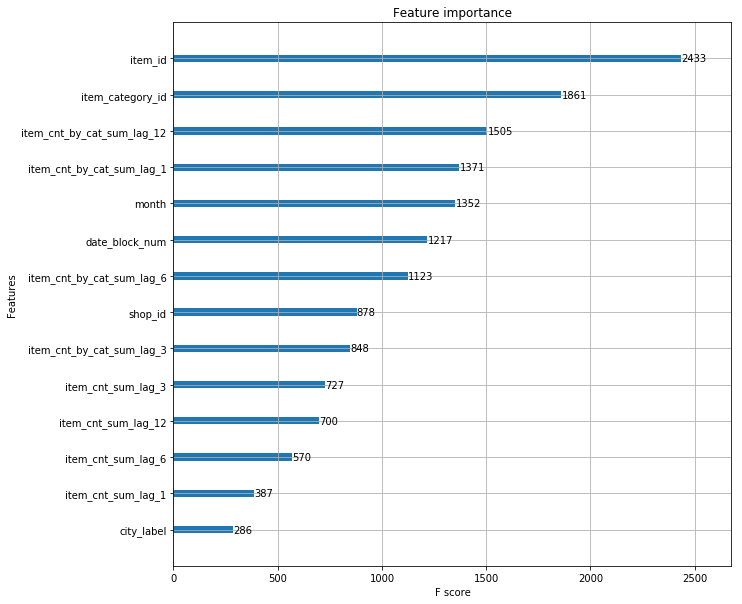

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
plot_importance(booster=model, ax=ax)

Save the model

In [32]:
import pickle

pickle.dump(model, open('model_20190618.dat','wb'))

## Create submission

In [33]:
y_test = np.clip(model.predict(x_test), 0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_test
})

submission.to_csv('xgb_submission.csv', index=False)